# 1.0 Imports

### 1.1 Libs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import tree as tr
from sklearn import metrics as mt
from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsClassifier

### 1.2 Loading data

In [2]:
df_raw = pd.read_csv('../datasets/train.csv', low_memory=False)

In [3]:
df_raw

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


# 2.0 Descrição dos dados

In [3]:
df1 = df_raw.copy()

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


### 2.1 Renomear colunas

In [4]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age',
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

### 2.2 Change types

In [5]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

### 2.3 Check NA 

In [7]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 2.4 Linhas duplicadas

In [8]:
linhas_duplicadas = df1[df1.duplicated()]
print("Linhas duplicadas:")
print(linhas_duplicadas)

Linhas duplicadas:
Empty DataFrame
Columns: [id, gender, age, driving_license, region_code, previously_insured, vehicle_age, vehicle_damage, annual_premium, policy_sales_channel, vintage, response]
Index: []


### 2.5 Estatística descritiva

In [16]:
stat_desc = df1.describe().T
stat_desc

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


In [6]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

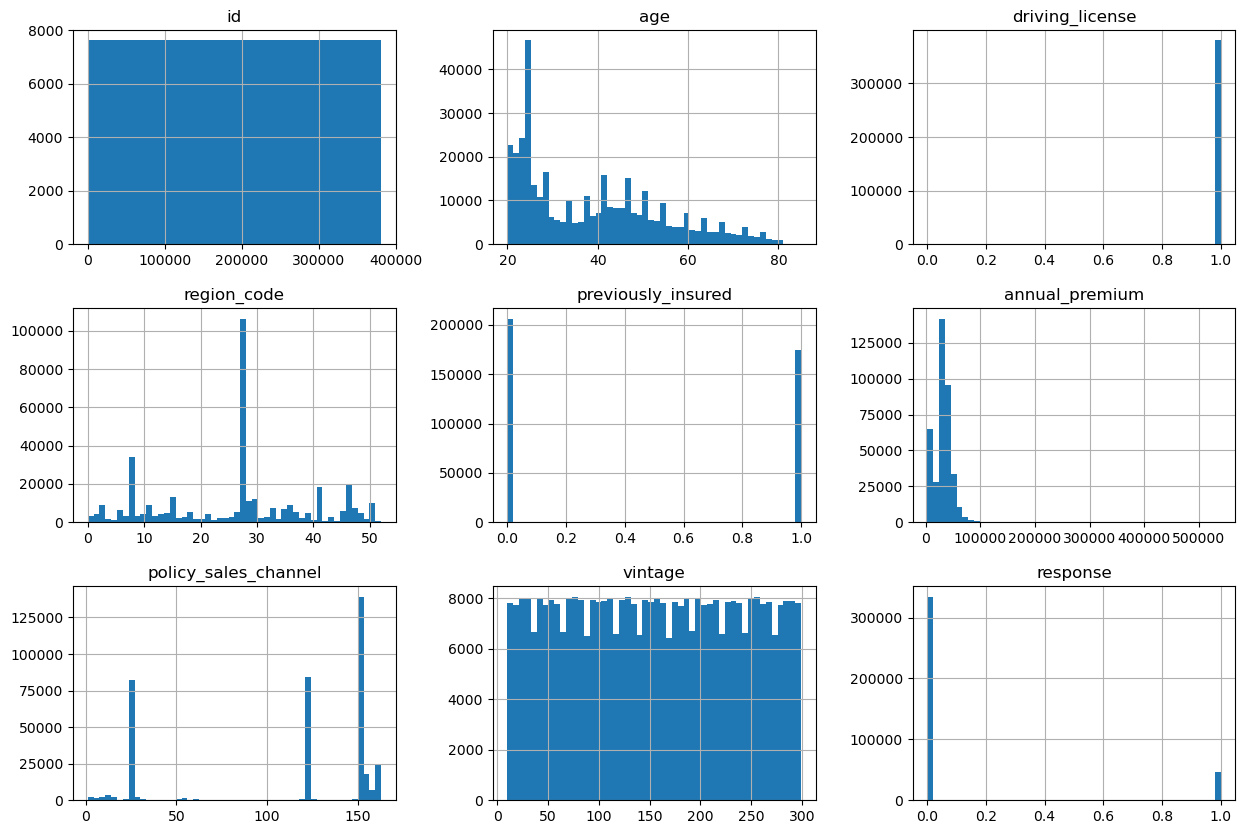

In [22]:
df1.hist(bins=50, figsize=(15,10));

In [71]:
cat_attributes.nunique()

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [74]:
a = df1['gender'].unique()
b = df1['vehicle_age'].unique()
c = df1['vehicle_damage'].unique()

print(a, b, c)

['Male' 'Female'] ['> 2 Years' '1-2 Year' '< 1 Year'] ['Yes' 'No']


# 3.0 Análise exploratória dos dados

In [7]:
df2 = df1.copy()

### 3.1 Featuring engineering

In [8]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over 2 years' if x == '> 2 Years' else '1-2 year' if x == '1-2 Year' else 'bellow 1 year')

### 3.2 Criação das hipóteses

In [ ]:
1 - Mulheres são mais propensas a aderirem ao seguro.
2 - Idosos são mais propensos a aderirem ao seguro.
3 - Quem não tem seguro-veículo é mais propenso a aderir ao seguro.
4 - Quem já bateu o carro é mais propenso a aderir ao seguro.
5 - Quem possui veículo novo é mais propenso a aderir ao seguro.
6 - Quem gasta mais com seguro-saúde é mais propenso a aderir ao seguro.
7 - Quem tem seguro a mais tempo é mais propenso a aderir ao seguro.
8 - Clientes de regiões específicas tem mais propensão a aderir ao seguro.
9 - Quem tem carteira de motorista tem mais propensão a aderir ao seguro.
10 - Meio de comunicação com o cliente afeta a propensão de aderir ao seguro.

In [ ]:
H1 - Mulheres são mais propensas a aderirem ao seguro. FALSA (tanto em número absoluto quanto em porcentagem)

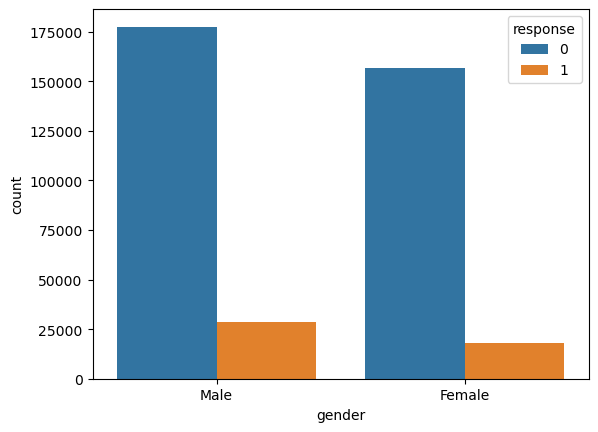

In [70]:
sns.countplot(data=df2, x='gender', hue='response');

In [ ]:
H2 - Idosos são mais propensos a aderirem ao seguro. FALSA (pessoas entre 40 e 50 anos são mais propensas)

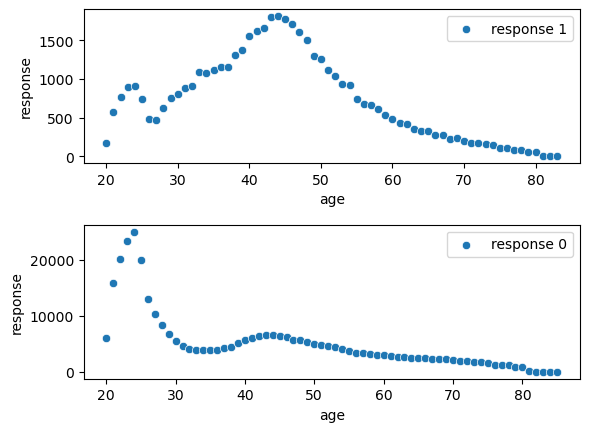

In [31]:
aux = df2[df2['response'] == 1]
aux1 = aux.groupby('age').count()
plt.subplot(2, 1, 1)
sns.scatterplot(x='age', y='response', data=aux1, label='response 1');

aux = df2[df2['response'] == 0]
aux1 = aux.groupby('age').count()
plt.subplot(2, 1, 2)
sns.scatterplot(x='age', y='response', data=aux1, label='response 0');
plt.subplots_adjust(hspace=0.4)

In [ ]:
H3 - Quem não tem seguro-veículo é mais propenso a aderir ao seguro. VERDADEIRA

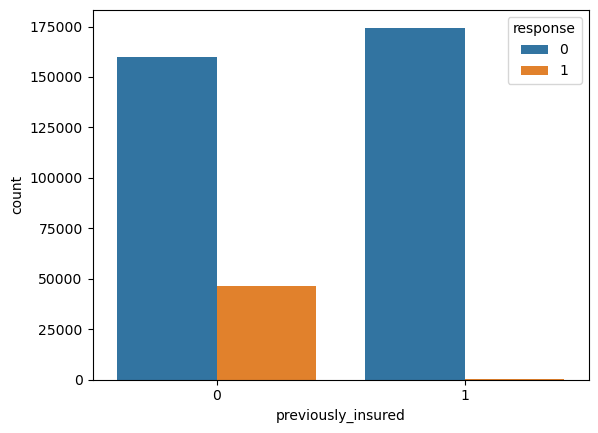

In [69]:
sns.countplot(data=df2, x='previously_insured', hue='response');

In [ ]:
H4 - Quem já bateu o carro é mais propenso a aderir ao seguro. VERDADEIRA

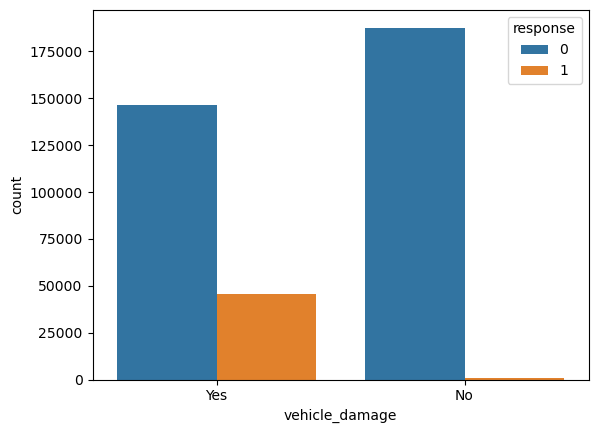

In [71]:
sns.countplot(data=df2, x='vehicle_damage', hue='response');

In [ ]:
H5 - Quem possui veículo novo é mais propenso a aderir ao seguro. FALSA (apesar de numericamente menor, proporcionalmente, 
quem tem veículos com mais de 2 anos são mais propensos a aderirem ao seguro)

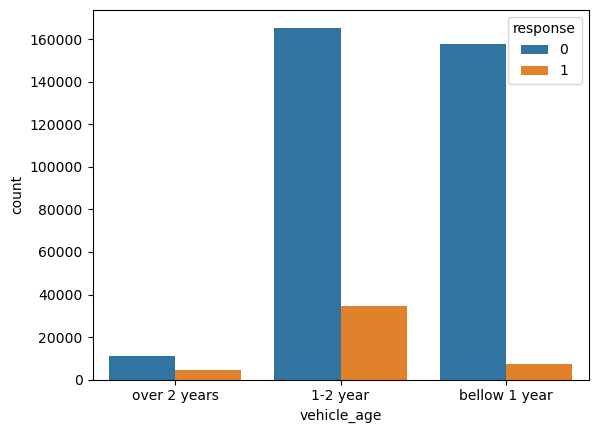

In [72]:
sns.countplot(data=df2, x='vehicle_age', hue='response');

In [ ]:
H6 - Quem gasta mais com seguro-saúde é mais propenso a aderir ao seguro. FALSA (quem gasta menos (2630.0) são mais propensos, 
seguidos por aqueles que gastam entre 20000 e 50000)

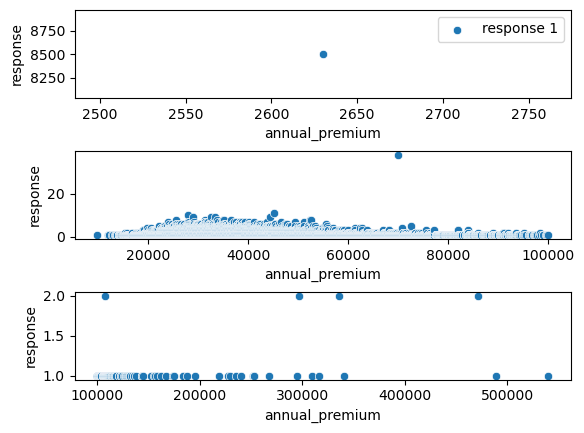

In [30]:
aux = df2[(df2['annual_premium'] < 3000.0) & (df2['response'] == 1)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 1);
sns.scatterplot(x='annual_premium', y='response', data=aux1, label='response 1');

aux = df2[(df2['annual_premium'] > 3000.0) & (df2['annual_premium'] < 100000.0) & (df2['response'] == 1)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 2);
sns.scatterplot(x='annual_premium', y='response', data=aux1);

aux = df2[(df2['annual_premium'] > 100000.0) & (df2['response'] == 1)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 3);
sns.scatterplot(x='annual_premium', y='response', data=aux1);
plt.subplots_adjust(hspace=0.6)

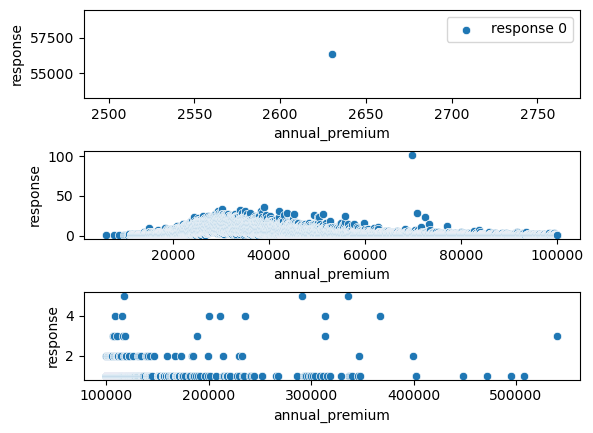

In [28]:
aux = df2[(df2['annual_premium'] < 3000.0) & (df2['response'] == 0)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 1);
sns.scatterplot(x='annual_premium', y='response', data=aux1, label='response 0');

aux = df2[(df2['annual_premium'] > 3000.0) & (df2['annual_premium'] < 100000.0) & (df2['response'] == 0)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 2);
sns.scatterplot(x='annual_premium', y='response', data=aux1);

aux = df2[(df2['annual_premium'] > 100000.0) & (df2['response'] == 0)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 3);
sns.scatterplot(x='annual_premium', y='response', data=aux1);
plt.subplots_adjust(hspace=0.6)

In [ ]:
H7 - Quem tem seguro a mais tempo é mais propenso a aderir ao seguro. FALSA (não parece haver relação entre as variáveis)

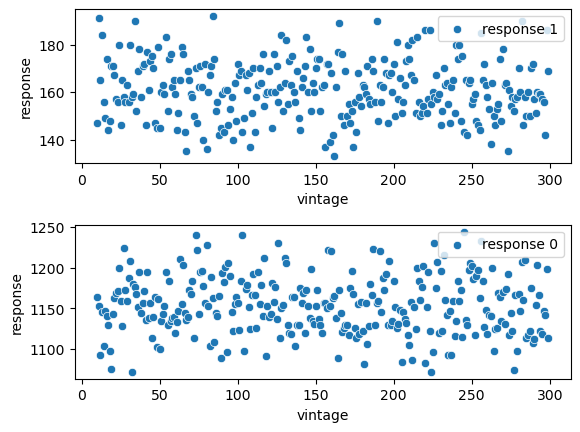

In [25]:
aux = df2[df2['response'] == 1]
aux1 = aux.groupby('vintage').count()
plt.subplot(2, 1, 1);
sns.scatterplot(x='vintage', y='response', data=aux1, label='response 1');

aux = df2[df2['response'] == 0]
aux1 = aux.groupby('vintage').count()
plt.subplot(2, 1, 2);
sns.scatterplot(x='vintage', y='response', data=aux1, label='response 0');
plt.subplots_adjust(hspace=0.4)

In [ ]:
H8 - Clientes de regiões específicas tem mais propensão a aderir ao seguro. FALSA (considerando que regiões com códigos próximos
estejam geograficamente próximas, não há relação. Algumas regiões apresentam melhores resultados, notavelmente a região 28, mas
não parece haver relação com a adesão ao seguro)

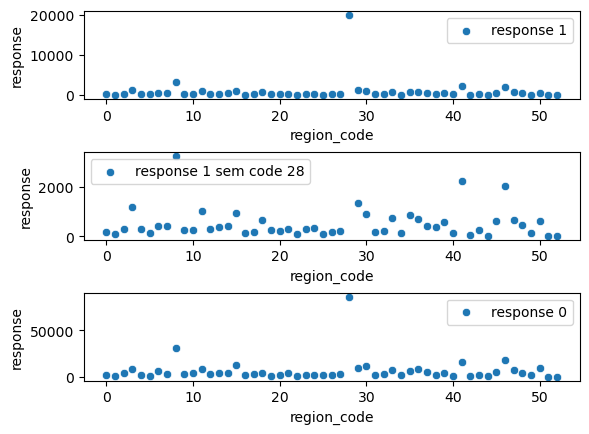

In [32]:
aux = df2[df2['response'] == 1]
aux1 = aux.groupby('region_code').count()
plt.subplot(3, 1, 1);
sns.scatterplot(x='region_code', y='response', data=aux1, label='response 1');

aux = df2[(df2['response'] == 1) & (df2['region_code'] != 28)]
aux1 = aux.groupby('region_code').count()
plt.subplot(3, 1, 2);
sns.scatterplot(x='region_code', y='response', data=aux1, label='response 1 sem code 28');

aux = df2[df2['response'] == 0]
aux1 = aux.groupby('region_code').count()
plt.subplot(3, 1, 3);
sns.scatterplot(x='region_code', y='response', data=aux1, label='response 0');
plt.subplots_adjust(hspace=0.6)

In [ ]:
H9 - Quem tem carteira de motorista tem mais propensão a aderir ao seguro. VERDADEIRA 

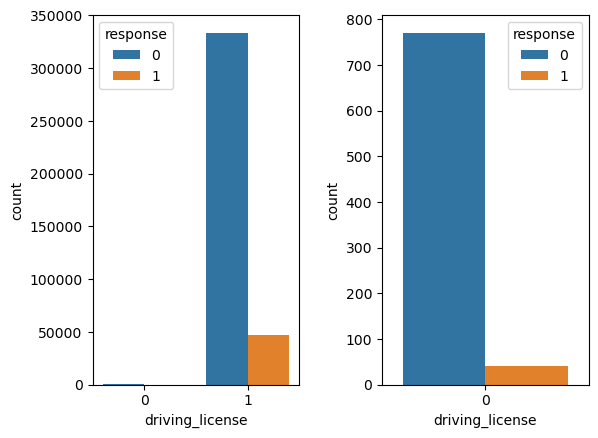

In [22]:
plt.subplot(1, 2, 1)
sns.countplot(data=df2, x='driving_license', hue='response');

plt.subplot(1, 2, 2)
aux = df2[(df2['driving_license'] == 0)]
sns.countplot(data=aux, x='driving_license', hue='response');
plt.subplots_adjust(wspace=0.4)

In [ ]:
H10 - Meio de comunicação com o cliente afeta a propensão de aderir ao seguro. VERDADEIRA (alguns tipo de comunicação tem 
resultados melhores)

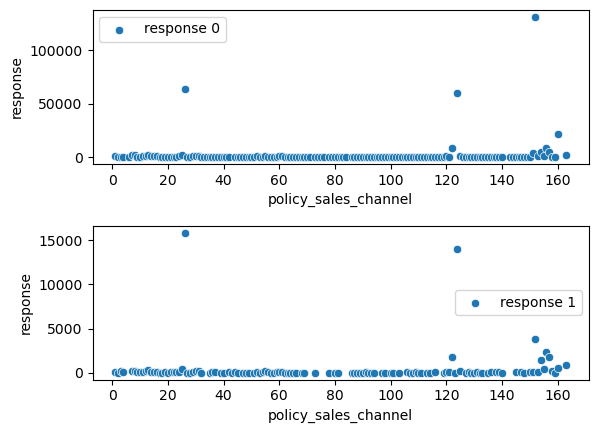

In [21]:
aux = df2[df2['response'] == 0]
aux1 = aux.groupby('policy_sales_channel').count()
plt.subplot(2, 1, 1);
sns.scatterplot(x='policy_sales_channel', y='response', data=aux1, label='response 0');

aux = df2[df2['response'] == 1]
aux1 = aux.groupby('policy_sales_channel').count()
plt.subplot(2, 1, 2);
sns.scatterplot(x='policy_sales_channel', y='response', data=aux1, label='response 1');
plt.subplots_adjust(hspace=0.4)

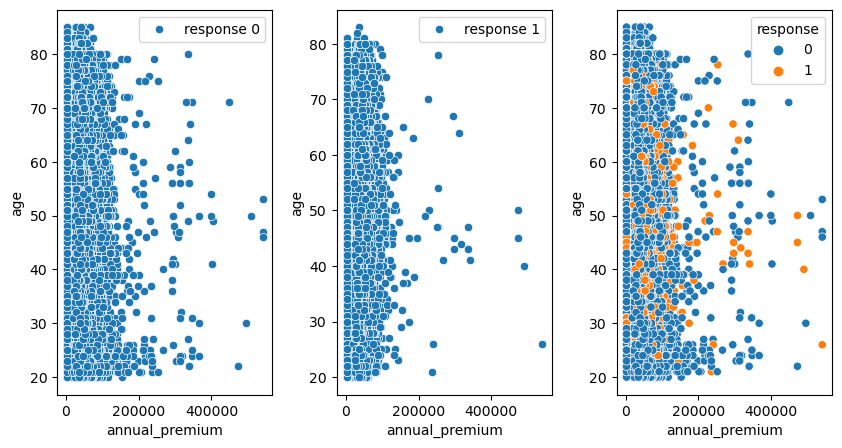

In [41]:
# Relação entre annual_premium e age:

plt.figure(figsize=(10, 5));
aux = df2[df2['response'] == 0]
plt.subplot(1, 3, 1)
sns.scatterplot(data=aux, x='annual_premium', y='age', label='response 0');

aux = df2[df2['response'] == 1]
plt.subplot(1, 3, 2)
sns.scatterplot(data=aux, x='annual_premium', y='age', label='response 1');

plt.subplot(1, 3, 3)
sns.scatterplot(data=df2, x='annual_premium', y='age', hue='response');

plt.subplots_adjust(wspace=0.3,hspace=0.1);

In [ ]:
Dos gráficos age x annual_premium: 
idosos tem annual_premium menores, 
há uma leve tendência que indica a diminuição do annual_premium com o aumento da idade

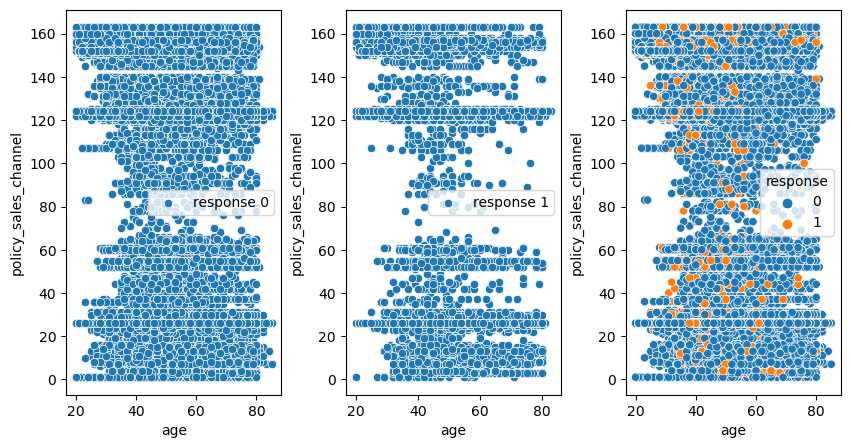

In [59]:
# Relação entre policy_sales_channel e age:

plt.figure(figsize=(10, 5));
aux = df2[df2['response'] == 0]
plt.subplot(1, 3, 1)
sns.scatterplot(data=aux, y='policy_sales_channel', x='age', label='response 0');

aux = df2[df2['response'] == 1]
plt.subplot(1, 3, 2)
sns.scatterplot(data=aux, y='policy_sales_channel', x='age', label='response 1');

plt.subplot(1, 3, 3)
sns.scatterplot(data=df2, y='policy_sales_channel', x='age', hue='response');

plt.subplots_adjust(wspace=0.3,hspace=0.1);

In [ ]:
Do gráfico policy_sales_channel x age:
há canais de comunicação que apresentaram resultados mais efetivos na adesão do seguro (indepedente da idade do cliente)

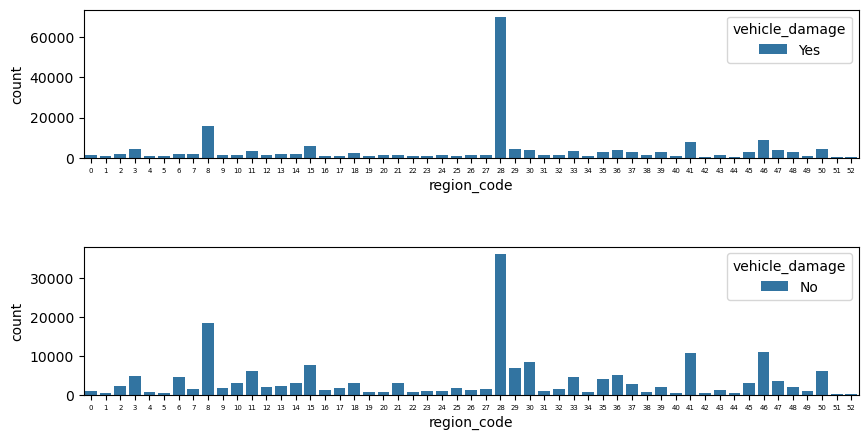

In [35]:
# Relação entre region_code e vehicle_damage:

plt.figure(figsize=(10, 5));
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 10
plt.subplot(2, 1, 1)
aux = df2[df2['vehicle_damage'] == 'Yes']
sns.countplot(data=aux, x='region_code', hue='vehicle_damage');

plt.subplot(2, 1, 2)
aux = df2[df2['vehicle_damage'] == 'No']
sns.countplot(data=aux, x='region_code', hue='vehicle_damage');

plt.subplots_adjust(wspace=0.1,hspace=0.6);

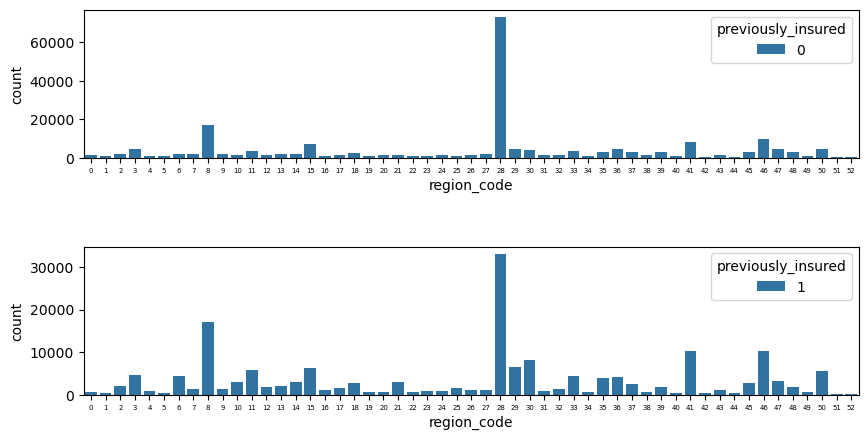

In [37]:
# Relação entre region_code e previously_insured:

plt.figure(figsize=(10, 5));
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 10
plt.subplot(2, 1, 1)
aux = df2[df2['previously_insured'] == 0]
sns.countplot(data=aux, x='region_code', hue='previously_insured');

plt.subplot(2, 1, 2)
aux = df2[df2['previously_insured'] == 1]
sns.countplot(data=aux, x='region_code', hue='previously_insured');

plt.subplots_adjust(wspace=0.1,hspace=0.6);

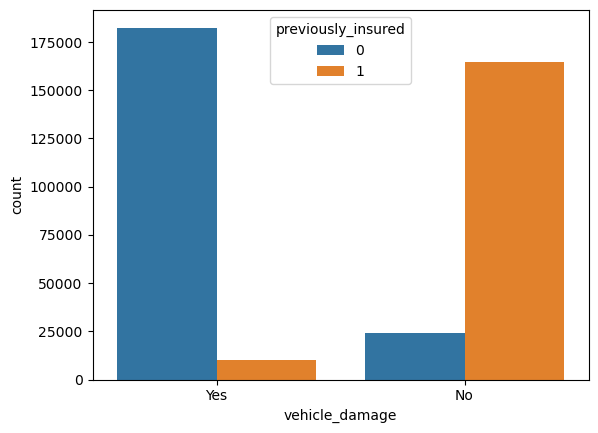

In [44]:
# Relação entre vehicle_damaged e previously_insured:

plt.rcParams['xtick.labelsize'] = 10
sns.countplot(data=df2, x='vehicle_damage', hue='previously_insured');

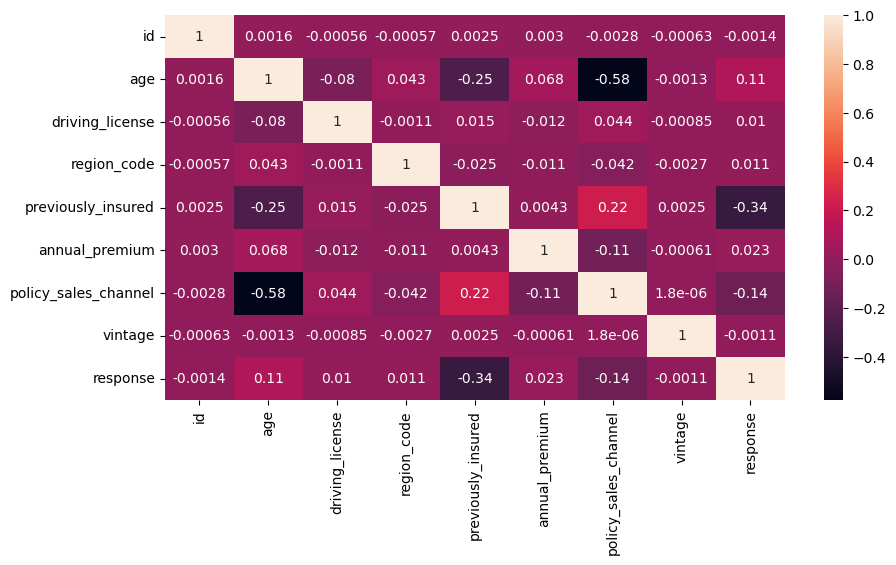

In [57]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(10, 5));
sns.heatmap(correlation, annot=True);

In [9]:
df2['gender'] = df2['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

df2 = pd.get_dummies(df2, columns=['vehicle_age'], dtype=int)

In [23]:
cat_attrib_featured = df2[['gender', 'vehicle_damage', 'vehicle_age_1-2 year', 'vehicle_age_bellow 1 year', 'vehicle_age_over 2 years', 'response']] 

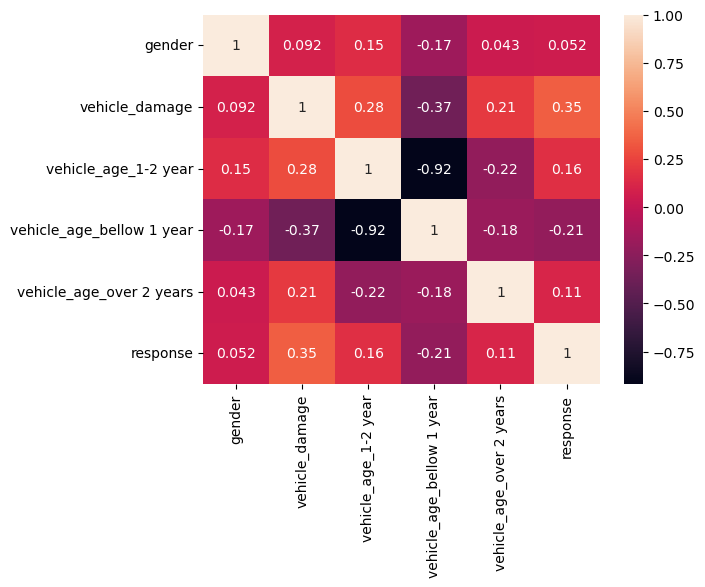

In [27]:
correlation = cat_attrib_featured.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 4.0 Preparação dos dados

In [10]:
df3 = df2.copy()

### 4.1 Rescaling

In [11]:
ss = pp.StandardScaler()
df3['annual_premium'] = ss.fit_transform(df3[['annual_premium']].values)

mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
df3['age'] = mms_age.fit_transform(df3[['age']].values)
df3['vintage'] = mms_vintage.fit_transform(df3[['vintage']].values)

### 4.2 Encoding

In [12]:
fe_policy_sales_channel = df3.groupby('policy_sales_channel').size() / len(df3) 
df3.loc[:, 'policy_sales_channel'] = df3['policy_sales_channel'].map(fe_policy_sales_channel)

fe_region_code = df3.groupby('region_code').size() / len(df3) 
df3.loc[:, 'region_code'] = df3['region_code'].map(fe_region_code)

### 4.3 Separação dos dados em train e validation 

In [13]:
X = df3.drop(['id', 'response'], axis=1)
y = df3['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df4 = pd.concat([x_train, y_train], axis=1)

### 4.4 Feature selection

In [59]:
rf = en.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

rf.feature_importances_

array([0.00903692, 0.1442872 , 0.00050788, 0.1000255 , 0.04657772,
       0.07339015, 0.25331484, 0.07328729, 0.28318188, 0.00477526,
       0.00904237, 0.00257299])

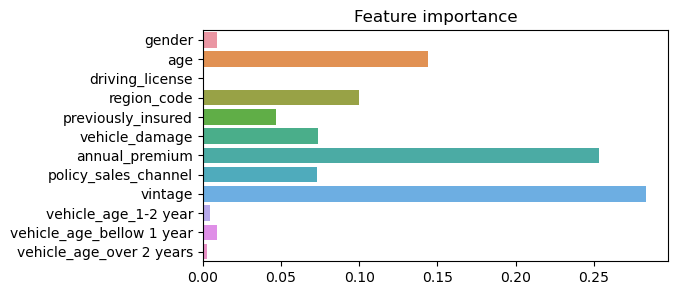

In [83]:
importances = pd.Series(data=rf.feature_importances_, index=x_train.columns)
plt.figure(figsize=(6, 3));
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Feature importance');

# 5.0 Machine learning

In [14]:
cols_selected = ['age', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium', 
                 'policy_sales_channel', 'vintage']

x_train = x_train[cols_selected]
x_validation = x_validation[cols_selected]

### 5.1 K-Nearest Neighbors

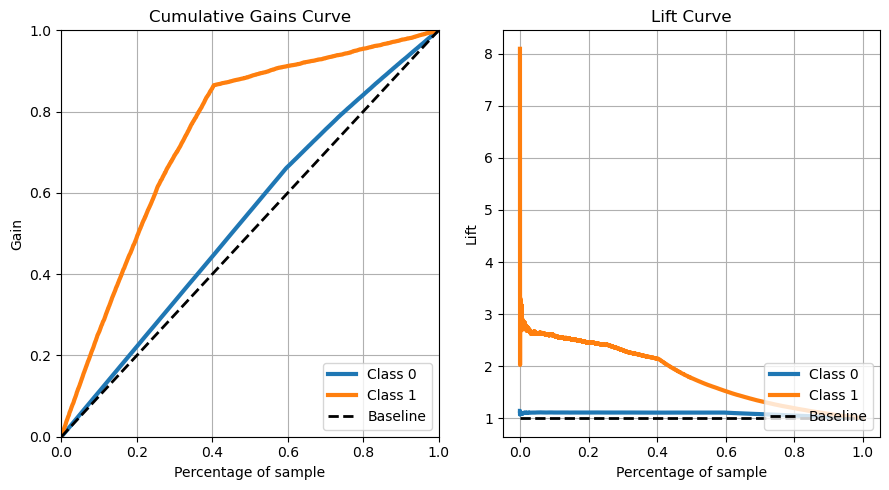

In [52]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(x_train, y_train)
yhat_knn = knn_classifier.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
# ganho acumulativo:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn, ax=axes[0]);
# lift curve:
skplt.metrics.plot_lift_curve(y_validation, yhat_knn, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.2 Decision Tree

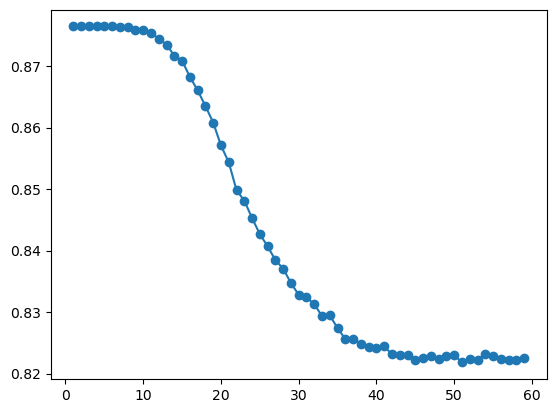

In [57]:
values = np.arange(1, 60, 1)
val_score = []

for i in values:
    tree = tr.DecisionTreeClassifier(max_depth=i)
    tree.fit(x_train, y_train)
    y_pred_val = tree.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

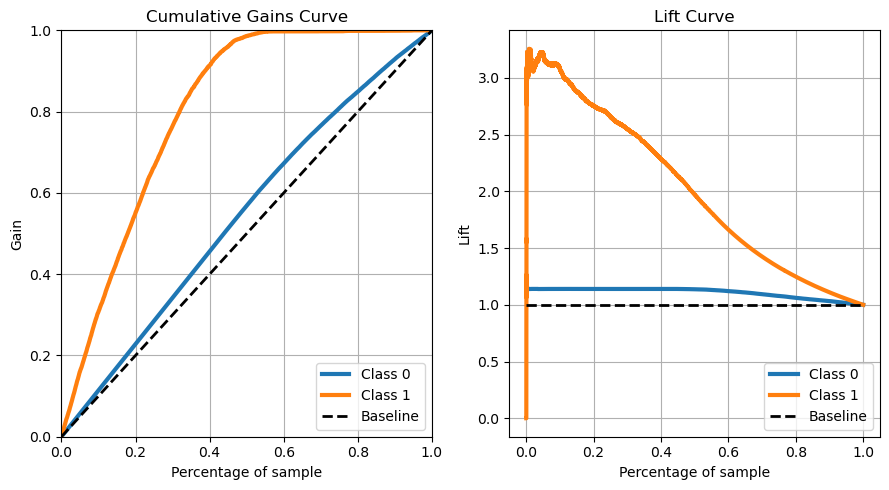

In [100]:
tree = tr.DecisionTreeClassifier(max_depth=8, random_state=42)
tree.fit(x_train, y_train)
yhat_tree = tree.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_tree, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_tree, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.3 Random Forest

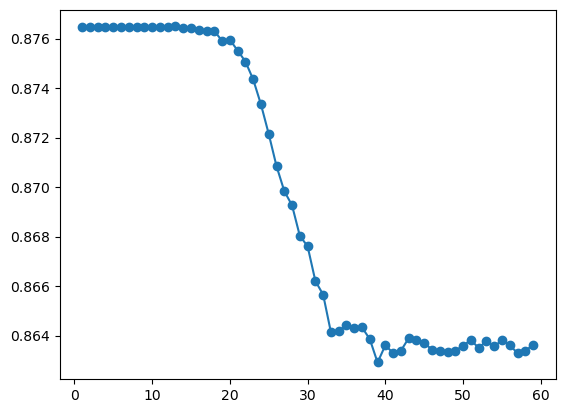

In [68]:
values = np.arange(1, 60, 1)
val_score = []

for i in values:
    random = en.RandomForestClassifier(max_depth=i, random_state=0)
    random.fit(x_train, y_train)
    y_pred_val = random.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

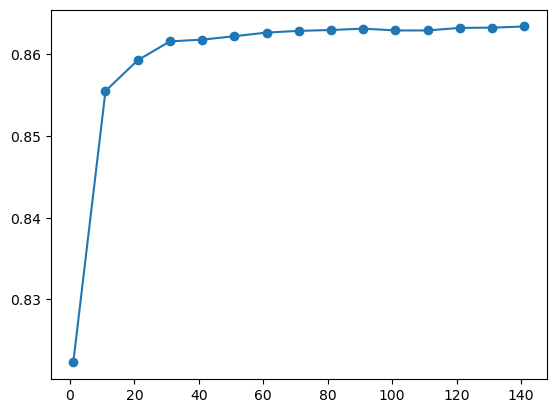

In [69]:
values = np.arange(1, 150, 10)
val_score = []

for i in values:
    random = en.RandomForestClassifier(n_estimators=i, random_state=0)
    random.fit(x_train, y_train)
    y_pred_val = random.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

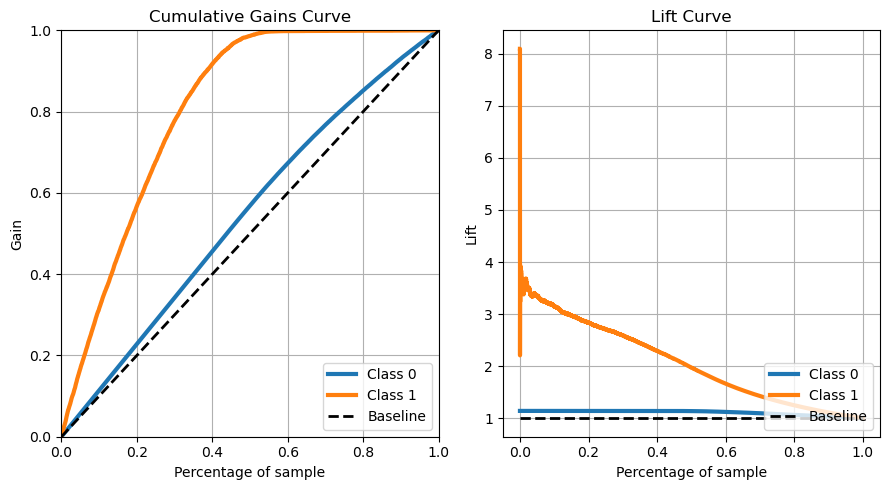

In [101]:
random = en.RandomForestClassifier(max_depth=13, n_estimators=140, random_state=0)
random.fit(x_train, y_train)
yhat_random = random.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_random, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_random, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.4  Logistic Regression

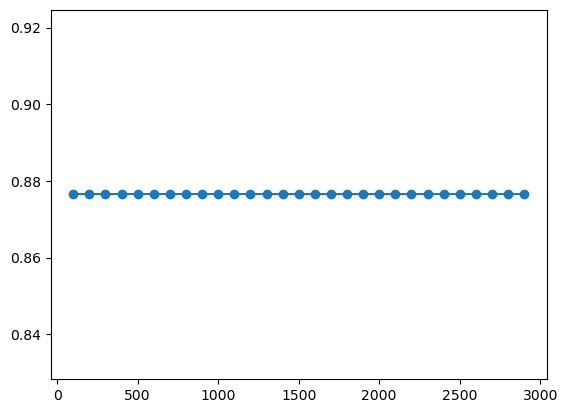

In [76]:
values = np.arange(100, 3000, 100)
val_score = []

for i in values:
    log_reg = lm.LogisticRegression(max_iter=i, random_state=0)
    log_reg.fit(x_train, y_train)
    y_pred_val = log_reg.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

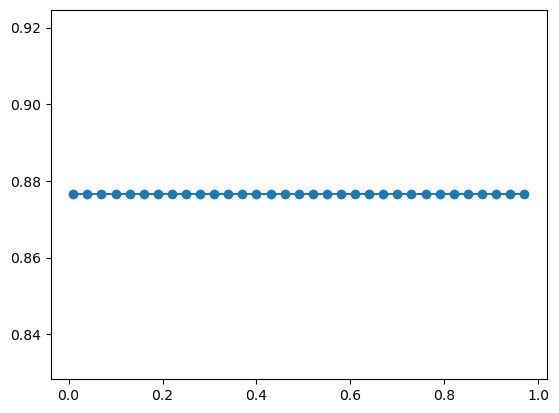

In [77]:
values = np.arange(0.01, 1.0, 0.03)
val_score = []

for i in values:
    log_reg = lm.LogisticRegression(C=i, random_state=0)
    log_reg.fit(x_train, y_train)
    y_pred_val = log_reg.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

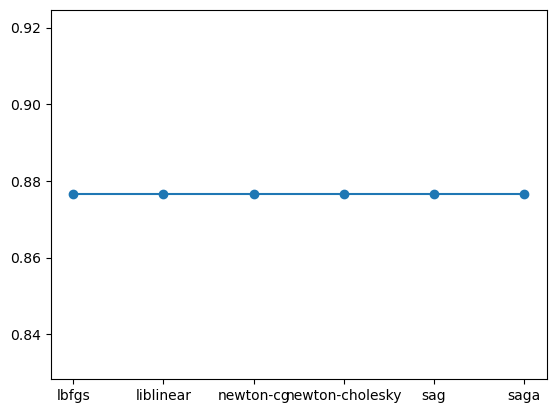

In [78]:
values = (['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
val_score = []

for i in values:
    log_reg = lm.LogisticRegression(solver=i, random_state=0)
    log_reg.fit(x_train, y_train)
    y_pred_val = log_reg.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

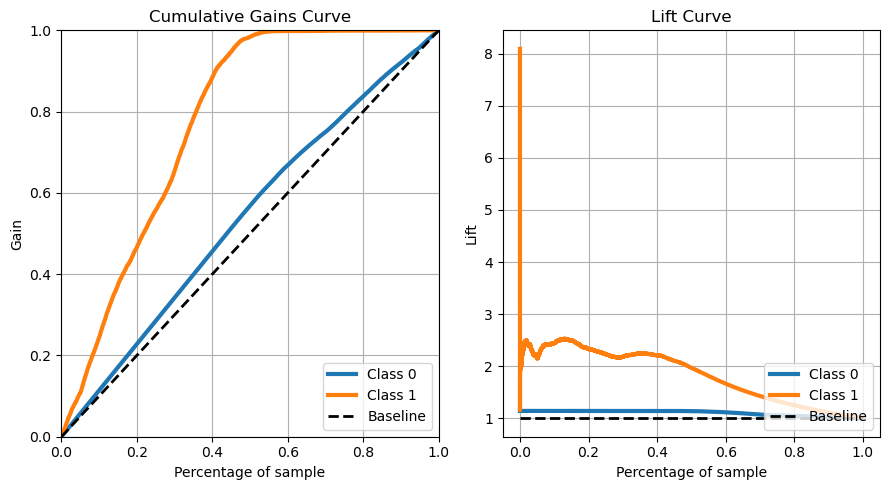

In [102]:
log_reg = lm.LogisticRegression(max_iter=1000, C=0.5, solver='newton-cg', random_state=0)
log_reg.fit(x_train, y_train)
yhat_log = log_reg.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_log, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_log, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.5 Xgboost

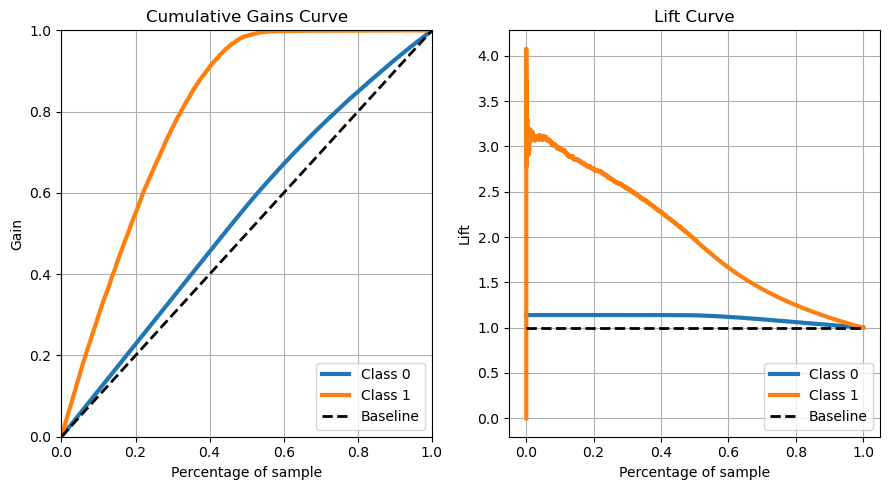

In [16]:
model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=10)
model_xgb.fit(x_train, y_train)
yhat_xgb = model_xgb.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb, ax=axes[1]);
plt.tight_layout()
plt.show()

# 6.0 Performance dos modelos 

In [20]:
def precision_at_k(data, k=1000):

    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']    

In [23]:
df5 = x_validation.copy()
df5['response'] = y_validation.copy()
df5['id'] = df5.index

# propensity score
df5['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df5 = df5.sort_values('score', ascending=False)

# compute precision_at_k
precision_at_50 = precision_at_k(df5, k=50)
print('Precision at k: {}'.format(precision_at_50))

Precision at k: 0.39215686274509803
